In [5]:
# Import some libraries

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')

!pip install scikeras
!pip install sastrawi
!pip install keras-preprocessing

import datetime as dt
import re
import string
import ast

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud


from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM, SpatialDropout1D
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\syair\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\syair\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Load data from a CSV file into pandas DataFrame

tweets_data = pd.read_csv(r"data_all.csv")
tweets_data.rename(columns={'username': 'account_name', 'handle': 'username', 'postDate': 'created_at', 'responding': 'tweet'}, inplace=True)

nama_kolom = tweets_data.columns

# Cetak daftar nama kolom
print("Nama-nama kolom dalam DataFrame:")
for nama in nama_kolom:
    print(nama)

Nama-nama kolom dalam DataFrame:
account_name
username
created_at
tweet
retweets
likes


In [7]:
tweets_sentimen = tweets_data[['account_name', 'username', 'created_at', 'tweet', 'retweets', 'likes']]
tweets_sentimen['tweet'] = tweets_sentimen['tweet'].apply(str)
print(tweets_sentimen.dtypes)

account_name    object
username        object
created_at      object
tweet           object
retweets        object
likes           object
dtype: object


In [8]:
print(tweets_sentimen.dtypes)

account_name    object
username        object
created_at      object
tweet           object
retweets        object
likes           object
dtype: object


In [9]:
my_file = open("data/combined_stop_words.txt", "r")
content = my_file.read()
stop_words = content.split("\n")
file_2  = open("data/update_combined_slang_words.txt", "r")
content2 = file_2.read()
slang_words = ast.literal_eval(content2)
my_file.close()
file_2.close()

In [10]:
# Some functions for preprocessing text

def cleaningText(text):
    my_file = open("data/combined_stop_words.txt", "r")
    content = my_file.read()
    stop_words = content.split("\n")
    file_2  = open("data/update_combined_slang_words.txt", "r")
    content2 = file_2.read()
    slang_words = ast.literal_eval(content2)
    my_file.close()
    file_2.close()

    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'^Replying to\s', '', text) # menghapus Replyting to
    text = re.sub(r'@\w+\s*', '', text) # menghapus mention
    text = re.sub(r'(?<!\w)and(?!\w)', '', text) # menghapus kata "and"
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # menghilangkan simbol â€™

    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    
    word_tokens = word_tokenize(text)
    for w in word_tokens:
        if w in slang_words.keys():
            word_tokens[word_tokens.index(w)] = slang_words[w]

    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []

    #looping through conditions
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in string.punctuation:
            filtered_tweet.append(w.lower())
    return ' '.join(filtered_tweet)

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower()
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [11]:
tweets_sentimen['text_clean'] = tweets_sentimen['tweet'].apply(cleaningText)
tweets_sentimen

,account_name,username,created_at,tweet,retweets,likes,text_clean
0,#TeruslahBergerak,@rezasilalahi,2023-09-08T14:59:33.000Z,Replying to \n@akbarfaizal68\n and \n@nagara_inst,NaN,NaN,
1,solichin jamaludin,@wakcis,2023-09-08T14:59:08.000Z,"Anies Baswedan bilang, pembangunan tak perlu o...",NaN,NaN,anies baswedan bilang pembangunan tidak perlu ...
2,Andi Manik,@Andi_Manik,2023-09-08T14:58:49.000Z,Replying to \n@sutanmangara,NaN,NaN,
3,Zulfikar Arma x,@ArmaZulfikar,2023-09-08T14:58:36.000Z,Replying to \n@sutanmangara,NaN,NaN,
4,rakyatjelita.com,@rakyatjelitacom,2023-09-08T14:58:24.000Z,Replying to \n@seruanhl\n @ch_chotimah2\n and ...,NaN,NaN,others
...,...,...,...,...,...,...,...
8231,Qwerty,@xaquily,2024-03-24T09:57:23.000Z,Membalas \n@G0P4NK_G0P4NG_7\n @aniesbaswedan\n...,NaN,NaN,membalas
8232,gibran basis bratson,@orangsurga,2024-03-24T09:57:23.000Z,Membalas \n@boraheamri\n @expebt\n dan 4 lainnya,NaN,NaN,membalas
8233,Gibran,@brangbrn,2024-03-24T09:57:19.000Z,Membalas \n@Ribka_JKT48,NaN,NaN,membalas
8234,MenolakMencret,@arwindras,2024-03-24T09:56:11.000Z,Membalas \n@olym_jae\n @littleg83443669\n dan...,NaN,NaN,membalas


In [12]:
tweets_sentimen['text_clean'] = tweets_sentimen['text_clean'].apply(casefoldingText)
tweets_sentimen

,account_name,username,created_at,tweet,retweets,likes,text_clean
0,#TeruslahBergerak,@rezasilalahi,2023-09-08T14:59:33.000Z,Replying to \n@akbarfaizal68\n and \n@nagara_inst,NaN,NaN,
1,solichin jamaludin,@wakcis,2023-09-08T14:59:08.000Z,"Anies Baswedan bilang, pembangunan tak perlu o...",NaN,NaN,anies baswedan bilang pembangunan tidak perlu ...
2,Andi Manik,@Andi_Manik,2023-09-08T14:58:49.000Z,Replying to \n@sutanmangara,NaN,NaN,
3,Zulfikar Arma x,@ArmaZulfikar,2023-09-08T14:58:36.000Z,Replying to \n@sutanmangara,NaN,NaN,
4,rakyatjelita.com,@rakyatjelitacom,2023-09-08T14:58:24.000Z,Replying to \n@seruanhl\n @ch_chotimah2\n and ...,NaN,NaN,others
...,...,...,...,...,...,...,...
8231,Qwerty,@xaquily,2024-03-24T09:57:23.000Z,Membalas \n@G0P4NK_G0P4NG_7\n @aniesbaswedan\n...,NaN,NaN,membalas
8232,gibran basis bratson,@orangsurga,2024-03-24T09:57:23.000Z,Membalas \n@boraheamri\n @expebt\n dan 4 lainnya,NaN,NaN,membalas
8233,Gibran,@brangbrn,2024-03-24T09:57:19.000Z,Membalas \n@Ribka_JKT48,NaN,NaN,membalas
8234,MenolakMencret,@arwindras,2024-03-24T09:56:11.000Z,Membalas \n@olym_jae\n @littleg83443669\n dan...,NaN,NaN,membalas


In [13]:
tweets_sentimen['text_preprocessed'] = tweets_sentimen['text_clean'].apply(tokenizingText)
tweets_sentimen['text_preprocessed'] = tweets_sentimen['text_preprocessed'].apply(filteringText)
tweets_sentimen['text_preprocessed'] = tweets_sentimen['text_preprocessed'].apply(stemmingText)

In [14]:
tweets_sentimen

,account_name,username,created_at,tweet,retweets,likes,text_clean,text_preprocessed
0,#TeruslahBergerak,@rezasilalahi,2023-09-08T14:59:33.000Z,Replying to \n@akbarfaizal68\n and \n@nagara_inst,NaN,NaN,,[]
1,solichin jamaludin,@wakcis,2023-09-08T14:59:08.000Z,"Anies Baswedan bilang, pembangunan tak perlu o...",NaN,NaN,anies baswedan bilang pembangunan tidak perlu ...,"[anies, baswedan, bilang, bangun, otot, anies,..."
2,Andi Manik,@Andi_Manik,2023-09-08T14:58:49.000Z,Replying to \n@sutanmangara,NaN,NaN,,[]
3,Zulfikar Arma x,@ArmaZulfikar,2023-09-08T14:58:36.000Z,Replying to \n@sutanmangara,NaN,NaN,,[]
4,rakyatjelita.com,@rakyatjelitacom,2023-09-08T14:58:24.000Z,Replying to \n@seruanhl\n @ch_chotimah2\n and ...,NaN,NaN,others,[others]
...,...,...,...,...,...,...,...,...
8231,Qwerty,@xaquily,2024-03-24T09:57:23.000Z,Membalas \n@G0P4NK_G0P4NG_7\n @aniesbaswedan\n...,NaN,NaN,membalas,[balas]
8232,gibran basis bratson,@orangsurga,2024-03-24T09:57:23.000Z,Membalas \n@boraheamri\n @expebt\n dan 4 lainnya,NaN,NaN,membalas,[balas]
8233,Gibran,@brangbrn,2024-03-24T09:57:19.000Z,Membalas \n@Ribka_JKT48,NaN,NaN,membalas,[balas]
8234,MenolakMencret,@arwindras,2024-03-24T09:56:11.000Z,Membalas \n@olym_jae\n @littleg83443669\n dan...,NaN,NaN,membalas,[balas]


In [15]:
# Preprocessing tweets data

tweets_sentimen['text_clean'] = tweets_sentimen['tweet'].apply(cleaningText)
tweets_sentimen['text_clean'] = tweets_sentimen['text_clean'].apply(casefoldingText)
#tweets_sentimen.drop(['tweet'], axis = 1, inplace = True)

tweets_sentimen['text_preprocessed'] = tweets_sentimen['text_clean'].apply(tokenizingText)
tweets_sentimen['text_preprocessed'] = tweets_sentimen['text_preprocessed'].apply(filteringText)
tweets_sentimen['text_preprocessed'] = tweets_sentimen['text_preprocessed'].apply(stemmingText)

# drop duplicates/spams tweets
tweets_sentimen.drop_duplicates(subset = 'text_clean', inplace = True)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000225E3627AF0>>
Traceback (most recent call last):
  File "c:\Users\syair\miniconda3\envs\sentimen-network\lib\site-packages\ipykernel\ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [285]:
tweets_sentimen = tweets_sentimen[tweets_sentimen['text_clean'].str.split().apply(len) > 1]

In [286]:
#tweets_sentimen.to_csv(r'data_clean_baru.csv', index = False, header = True,index_label=None)

In [287]:
#tweets_sentimen = pd.read_csv('data_clean_baru.csv')

In [288]:
# Determine sentiment polarity of tweets using indonesia sentiment lexicon (source : https://github.com/fajri91/InSet)

# Loads lexicon positive and negative data
lexicon_positive = dict()
import csv
with open('data/lexicon_positive.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
import csv
with open('data/lexicon_negative.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])

# Function to determine sentiment polarity of tweets
def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    polarity=''
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

In [289]:
# Results from determine sentiment polarity of tweets

results = tweets_sentimen['text_preprocessed'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
tweets_sentimen['polarity_score'] = results[0]
tweets_sentimen['polarity'] = results[1]
print(tweets_sentimen['polarity'].value_counts())

# Export to csv file
#tweets_sentimen.to_csv(r'tweets_data_clean_polarity1.csv', index = False, header = True,index_label=None)

tweets_sentimen

polarity
positive    1262
negative    1096
neutral      267
Name: count, dtype: int64


,account_name,username,created_at,tweet,retweets,likes,text_clean,text_preprocessed,polarity_score,polarity
1,solichin jamaludin,@wakcis,2023-09-08T14:59:08.000Z,"Anies Baswedan bilang, pembangunan tak perlu otot. Demikian disampaikan Anies menyindir kepala BP Batam, yg merupakan ketua Nasdem Kepri.",NaN,NaN,anies baswedan bilang pembangunan tak perlu otot demikian disampaikan anies menyindir kepala bp batam yg merupakan ketua nasdem kepri,"[anies, baswedan, bilang, bangun, otot, anies, sindir, kepala, bp, batam, yg, ketua, nasdem, kepri]",-7,negative
5,Kota-kota Indonesia: Pengantar untuk Orang Banyak,@mkusumawijaya,2023-09-08T14:58:16.000Z,"Hibahkan Hotel Untuk Posko Induk Pemenangan, MRR: Diresmikan Anies 24 September - Fokusatu",NaN,NaN,hibahkan hotel untuk posko induk pemenangan mrr diresmikan anies september fokusatu,"[hibah, hotel, posko, induk, menang, mrr, resmi, anies, september, fokusatu]",6,positive
8,Rustan Sello,@Rustansello,2023-09-08T14:55:29.000Z,"Ketika Anies ingin memilih AHY sbg Cawapres, pihak Nasdem menyebutkan Anies berkhianat.\n\nPD Bongkar Fakta",NaN,NaN,ketika anies ingin memilih ahy sbg cawapres pihak nasdem menyebutkan anies berkhianat pd bongkar fakta,"[anies, pilih, ahy, sbg, cawapres, nasdem, anies, khianat, pd, bongkar, fakta]",-12,negative
14,Trousie,@cheapdoughnuts,2023-09-08T14:53:26.000Z,I’d go for pak anies moodboard,NaN,NaN,id go for pak anies moodboard,"[id, go, for, anies, moodboard]",0,neutral
18,𝓗𝓪𝓫𝓲𝓫𝓪𝓷𝓪𝓷𝓪™,@rizieqdivist,2023-09-08T14:50:56.000Z,"Anies mbatin:\n""Wah, ente belum pernah ngerasain jurus andalan ane ya? Awas, ntar ane khianati, baru tau rasa ente!""",NaN,NaN,anies mbatin wah ente belum pernah ngerasain jurus andalan ane ya awas ntar ane khianati baru tau rasa ente,"[anies, mbatin, ente, ngerasain, jurus, andal, ane, ya, awas, ntar, ane, khianat, tau, ente]",0,neutral
...,...,...,...,...,...,...,...,...,...,...
8213,B. Prasetya,@BANGSAygSUJUD,2024-03-24T10:07:07.000Z,"Seharusnya Kemendes diberi ruang lebih besar dalam Percepatan Penanggulangan Kemiskinan \n\nTentu dibutuhkan Menteri yg peduli serta berpikir seperti CEO bukan sekedar menteri yg berpikir rutinitas belaka\n\nMajulah desa, majulah Indonesia \n@prabowo\n @gibran_tweet\n@budimandjatmiko",8.0,18.0,seharusnya kemendes diberi ruang lebih besar dalam percepatan penanggulangan kemiskinan tentu dibutuhkan menteri yg peduli serta berpikir seperti ceo bukan sekedar menteri yg berpikir rutinitas belaka majulah desa majulah indonesia,"[kemendes, ruang, cepat, tanggulang, miskin, butuh, menteri, yg, peduli, pikir, ceo, dar, menteri, yg, pikir, rutinitas, belaka, maju, desa, maju, indonesia]",-11,negative
8218,gibran basis bratson,@orangsurga,2024-03-24T10:05:22.000Z,si gibran kebanyakan mabok,NaN,NaN,si gibran kebanyakan mabok,"[si, gibran, banyak, mabok]",-4,negative
8221,HijiBerita,@hijiberita,2024-03-24T10:01:42.000Z,"Capres No. 3 Ganjar-Mahfud\n\nTPN tuntut Pemilu 2024 diulang tanpa Prabowo-Gibran, di seluruh Indonesia.\nhttps://youtube.com/watch?v=qIWeUhHisao…\n\nBarakallahu laka wa baraka 'alaika wa jama'a bainakuma fii khairin: Habib Rizieq Shihab Menikahi Syarifah Mona Hasinah Alaydrus",1.0,NaN,capres no ganjarmahfud tpn tuntut pemilu diulang tanpa prabowogibran di seluruh indonesia barakallahu laka wa baraka alaika wa jamaa bainakuma fii khairin habib rizieq shihab menikahi syarifah mona hasinah alaydrus,"[capres, no, ganjarmahfud, tpn, tuntut, milu, ulang, prabowogibran, indonesia, barakallahu, laka, wa, baraka, alaika, wa, jamaa, bainakuma, fii, khairin, habib, rizieq, shihab, nikah, syarifah, mona, hasinah, alaydrus]",-4,negative
8222,Tribun Kaltim,@tribunkaltim,2024-03-24T10:01:41.000Z,"Minta Gibran Didiskualifikasi, Gugatan Anies dan Ganjar Dinilai Salah Alamat, Yusril: Aneh!\nhttps://kaltim.tribunnews.com/2024/03/24/minta-gibran-didiskualifikasi-gugatan-anies-dan-ganjar-dinilai-salah-alamat-yusril-aneh… lewat \n@tribunnews\n \n\n#Pilpres #Pemilu2024 #Gibran #Anies #Ganjar",NaN,NaN,minta gibran didiskualifika

In [290]:
# Make text preprocessed (tokenized) to untokenized with toSentence Function
X = tweets_sentimen['text_preprocessed'].apply(toSentence)
max_features = 9000

# Tokenize text with specific maximum number of words to keep, based on word frequency
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)
X.shape


(2625, 50)

In [291]:
import pickle
with open('sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [346]:
polarity_encode = {'negative' : 0, 'neutral' : 1, 'positive' : 2}
y = tweets_sentimen['polarity'].map(polarity_encode).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2100, 50) (2100,)
(525, 50) (525,)


In [347]:
#model
def create_model(embed_dim = 16, hidden_unit = 32, dropout_rate = 0.2, optimizers = Adam, learning_rate = 0.001):
    model = Sequential()
    model.add(Embedding(input_dim = max_features, output_dim = embed_dim, input_length = X_train.shape[1]))
    model.add(LSTM(units = hidden_unit, activation = 'tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers(lr = learning_rate), metrics = ['accuracy'])
    print(model.summary())
    return model


In [378]:
# From results above, we know the best hyperparameter for this model is :
# {'batch_size': 128, 'dropout_rate': 0.2, 'embed_dim': 32, 'epochs': 10, 'hidden_unit': 16, 'learning_rate': 0.001, 'optimizers': <class 'keras.optimizers.RMSprop'>}
model = KerasClassifier(model = create_model,
                        # Model Parameters
                        dropout_rate = 0.2,
                        embed_dim = 32,
                        hidden_unit = 32,
                        optimizers = RMSprop,
                        learning_rate = 0.001,

                        # Fit Parameters
                        epochs=50,
                        batch_size=128,
                        validation_split = 0.1)


model_prediction = model.fit(X_train, y_train)

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_63 (Embedding)    (None, 50, 32)            288000    
                                                                 
 lstm_62 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_64 (Dropout)        (None, 32)                0         
                                                                 
 dense_64 (Dense)            (None, 3)                 99        
                                                                 
Total params: 296,419
Trainable params: 296,419
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50


C:\Users\syair\miniconda3\envs\sentimen-network\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


15/15 [==============================] - 5s 121ms/step - loss: 1.0305 - accuracy: 0.4878 - val_loss: 0.9449 - val_accuracy: 0.4810
Epoch 2/50
15/15 [==============================] - 1s 55ms/step - loss: 0.9467 - accuracy: 0.5344 - val_loss: 0.9102 - val_accuracy: 0.4857
Epoch 3/50
15/15 [==============================] - 1s 64ms/step - loss: 0.8851 - accuracy: 0.6302 - val_loss: 0.8333 - val_accuracy: 0.6476
Epoch 4/50
15/15 [==============================] - 1s 56ms/step - loss: 0.7878 - accuracy: 0.7148 - val_loss: 0.7529 - val_accuracy: 0.6762
Epoch 5/50
15/15 [==============================] - 1s 55ms/step - loss: 0.6581 - accuracy: 0.7683 - val_loss: 0.6765 - val_accuracy: 0.7048
Epoch 6/50
15/15 [==============================] - 1s 68ms/step - loss: 0.5656 - accuracy: 0.8042 - val_loss: 0.6902 - val_accuracy: 0.6762
Epoch 7/50
15/15 [==============================] - 1s 51ms/step - loss: 0.4920 - accuracy: 0.8280 - val_loss: 0.8065 - val_accuracy: 0.6857
Epoch 8/50
15/15 [=====

In [352]:
from sklearn.model_selection import StratifiedKFold

# Initialize StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store results from each fold
accuracy_scores = []

# Iterate through each fold
for train_index, val_index in kfold.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Fit model on training fold
    model.fit(X_train_fold, y_train_fold)
    
    # Evaluate model on validation fold
    accuracy = model.score(X_val_fold, y_val_fold)
    accuracy_scores.append(accuracy)

# Calculate average accuracy across folds
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print("Average accuracy across folds:", avg_accuracy)


Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_58 (Embedding)    (None, 50, 32)            288000    
                                                                 
 lstm_57 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_59 (Dropout)        (None, 32)                0         
                                                                 
 dense_59 (Dense)            (None, 3)                 99        
                                                                 
Total params: 296,419
Trainable params: 296,419
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50


C:\Users\syair\miniconda3\envs\sentimen-network\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


12/12 [==============================] - 4s 127ms/step - loss: 1.0234 - accuracy: 0.4630 - val_loss: 0.9488 - val_accuracy: 0.4821
Epoch 2/50
12/12 [==============================] - 1s 77ms/step - loss: 0.9531 - accuracy: 0.4934 - val_loss: 0.9338 - val_accuracy: 0.5179
Epoch 3/50
12/12 [==============================] - 1s 75ms/step - loss: 0.9307 - accuracy: 0.5866 - val_loss: 0.9071 - val_accuracy: 0.5000
Epoch 4/50
12/12 [==============================] - 1s 54ms/step - loss: 0.8788 - accuracy: 0.6336 - val_loss: 0.8485 - val_accuracy: 0.6667
Epoch 5/50
12/12 [==============================] - 1s 60ms/step - loss: 0.7886 - accuracy: 0.7063 - val_loss: 0.7762 - val_accuracy: 0.7024
Epoch 6/50
12/12 [==============================] - 1s 67ms/step - loss: 0.6902 - accuracy: 0.7593 - val_loss: 0.7027 - val_accuracy: 0.7024
Epoch 7/50
12/12 [==============================] - 1s 57ms/step - loss: 0.6024 - accuracy: 0.7917 - val_loss: 0.6577 - val_accuracy: 0.7143
Epoch 8/50
12/12 [=====

C:\Users\syair\miniconda3\envs\sentimen-network\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


12/12 [==============================] - 3s 106ms/step - loss: 1.0264 - accuracy: 0.4550 - val_loss: 0.9498 - val_accuracy: 0.4524
Epoch 2/50
12/12 [==============================] - 1s 57ms/step - loss: 0.9476 - accuracy: 0.5218 - val_loss: 0.9225 - val_accuracy: 0.5417
Epoch 3/50
12/12 [==============================] - 1s 56ms/step - loss: 0.9175 - accuracy: 0.5899 - val_loss: 0.8853 - val_accuracy: 0.6071
Epoch 4/50
12/12 [==============================] - 1s 67ms/step - loss: 0.8428 - accuracy: 0.6931 - val_loss: 0.8161 - val_accuracy: 0.6607
Epoch 5/50
12/12 [==============================] - 1s 58ms/step - loss: 0.7533 - accuracy: 0.7235 - val_loss: 0.7904 - val_accuracy: 0.6488
Epoch 6/50
12/12 [==============================] - 1s 57ms/step - loss: 0.6552 - accuracy: 0.7612 - val_loss: 0.7097 - val_accuracy: 0.7143
Epoch 7/50
12/12 [==============================] - 1s 57ms/step - loss: 0.5740 - accuracy: 0.8036 - val_loss: 0.6889 - val_accuracy: 0.6667
Epoch 8/50
12/12 [=====

C:\Users\syair\miniconda3\envs\sentimen-network\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


12/12 [==============================] - 3s 110ms/step - loss: 1.0309 - accuracy: 0.4246 - val_loss: 0.9612 - val_accuracy: 0.4762
Epoch 2/50
12/12 [==============================] - 1s 58ms/step - loss: 0.9575 - accuracy: 0.4802 - val_loss: 0.9478 - val_accuracy: 0.4821
Epoch 3/50
12/12 [==============================] - 1s 57ms/step - loss: 0.9379 - accuracy: 0.5344 - val_loss: 0.9285 - val_accuracy: 0.5119
Epoch 4/50
12/12 [==============================] - 1s 69ms/step - loss: 0.8985 - accuracy: 0.5880 - val_loss: 0.8923 - val_accuracy: 0.6250
Epoch 5/50
12/12 [==============================] - 1s 57ms/step - loss: 0.8197 - accuracy: 0.6984 - val_loss: 0.8491 - val_accuracy: 0.6726
Epoch 6/50
12/12 [==============================] - 1s 67ms/step - loss: 0.7446 - accuracy: 0.7474 - val_loss: 0.7761 - val_accuracy: 0.6488
Epoch 7/50
12/12 [==============================] - 1s 59ms/step - loss: 0.6489 - accuracy: 0.7738 - val_loss: 0.7433 - val_accuracy: 0.6607
Epoch 8/50
12/12 [=====

C:\Users\syair\miniconda3\envs\sentimen-network\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


12/12 [==============================] - 4s 114ms/step - loss: 1.0174 - accuracy: 0.4716 - val_loss: 0.9213 - val_accuracy: 0.4643
Epoch 2/50
12/12 [==============================] - 1s 57ms/step - loss: 0.9624 - accuracy: 0.4828 - val_loss: 0.8839 - val_accuracy: 0.5357
Epoch 3/50
12/12 [==============================] - 1s 57ms/step - loss: 0.9331 - accuracy: 0.5443 - val_loss: 0.8786 - val_accuracy: 0.6369
Epoch 4/50
12/12 [==============================] - 1s 58ms/step - loss: 0.8790 - accuracy: 0.6336 - val_loss: 0.7934 - val_accuracy: 0.6548
Epoch 5/50
12/12 [==============================] - 1s 58ms/step - loss: 0.7959 - accuracy: 0.6971 - val_loss: 0.7189 - val_accuracy: 0.7083
Epoch 6/50
12/12 [==============================] - 1s 68ms/step - loss: 0.6986 - accuracy: 0.7507 - val_loss: 0.6801 - val_accuracy: 0.7143
Epoch 7/50
12/12 [==============================] - 1s 58ms/step - loss: 0.6007 - accuracy: 0.7996 - val_loss: 0.6409 - val_accuracy: 0.7500
Epoch 8/50
12/12 [=====

C:\Users\syair\miniconda3\envs\sentimen-network\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


12/12 [==============================] - 3s 110ms/step - loss: 1.0356 - accuracy: 0.4749 - val_loss: 0.9414 - val_accuracy: 0.4821
Epoch 2/50
12/12 [==============================] - 1s 66ms/step - loss: 0.9481 - accuracy: 0.5033 - val_loss: 0.9076 - val_accuracy: 0.5000
Epoch 3/50
12/12 [==============================] - 1s 63ms/step - loss: 0.9180 - accuracy: 0.5741 - val_loss: 0.8722 - val_accuracy: 0.5952
Epoch 4/50
12/12 [==============================] - 1s 60ms/step - loss: 0.8647 - accuracy: 0.6713 - val_loss: 0.8260 - val_accuracy: 0.6131
Epoch 5/50
12/12 [==============================] - 1s 60ms/step - loss: 0.7820 - accuracy: 0.7077 - val_loss: 0.7625 - val_accuracy: 0.6905
Epoch 6/50
12/12 [==============================] - 1s 60ms/step - loss: 0.6792 - accuracy: 0.7632 - val_loss: 0.7219 - val_accuracy: 0.6667
Epoch 7/50
12/12 [==============================] - 1s 71ms/step - loss: 0.6038 - accuracy: 0.7884 - val_loss: 0.6800 - val_accuracy: 0.6845
Epoch 8/50
12/12 [=====

In [ ]:
'''
from imblearn.under_sampling import TomekLinks

# Create TomekLinks undersampler
tl = TomekLinks()

# Undersample the data
X_train_resampled, y_train_resampled = tl.fit_resample(X_train, y_train)

print("Before UnderSampling, counts of label '0': {}".format(sum(y_train == 0)))
print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '2': {}".format(sum(y_train == 2)))

print("After UnderSampling, counts of label '0': {}".format(sum(y_train_resampled == 0)))
print("After UnderSampling, counts of label '1': {}".format(sum(y_train_resampled == 1)))
print("After UnderSampling, counts of label '2': {}".format(sum(y_train_resampled == 2)))
model = KerasClassifier(model = create_model,
                        # Model Parameters
                        dropout_rate = 0.2,
                        embed_dim = 32,
                        hidden_unit = 16,
                        optimizers = Adam,
                        learning_rate = 0.001,

                        # Fit Parameters
                        epochs=100,
                        batch_size=64,
                        validation_split = 0.01)

model_prediction = model.fit(X_train_resampled, y_train_resampled)
'''


In [379]:
results = model.score(X_test,y_test)
print(results)

5/5 [==============================] - 1s 60ms/step
0.7466666666666667


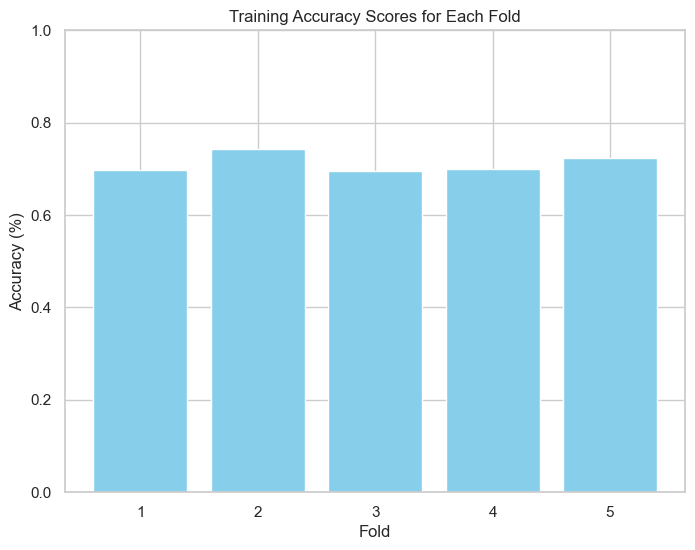

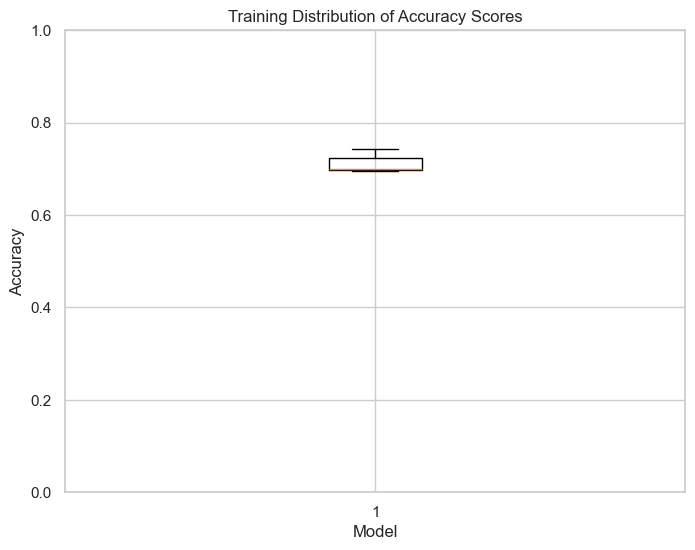

Average accuracy across folds: 0.7119047619047618


In [354]:
import matplotlib.pyplot as plt

# Plot accuracy scores for each fold
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(accuracy_scores)+1), accuracy_scores, color='skyblue')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Scores for Each Fold')
plt.ylim(0, 1)  # Set y-axis limit to ensure consistency
plt.show()

# Print average accuracy across folds
print("Average accuracy across folds:", avg_accuracy)


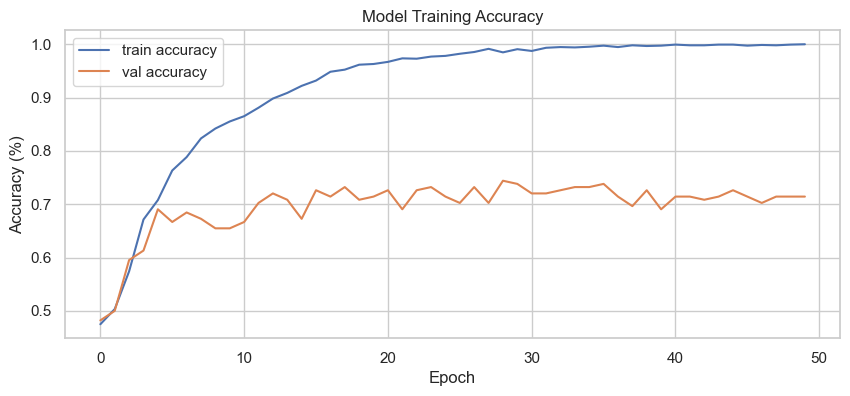

In [355]:
# Visualization model accuracy (train and val accuracy)

fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(model_prediction.history_['accuracy'], label = 'train accuracy')
ax.plot(model_prediction.history_['val_accuracy'], label = 'val accuracy')
ax.set_title('Model Training Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (%)')
ax.legend(loc = 'upper left')
plt.show()

5/5 [==============================] - 0s 19ms/step
Model Accuracy on Test Data: 0.7142857142857143


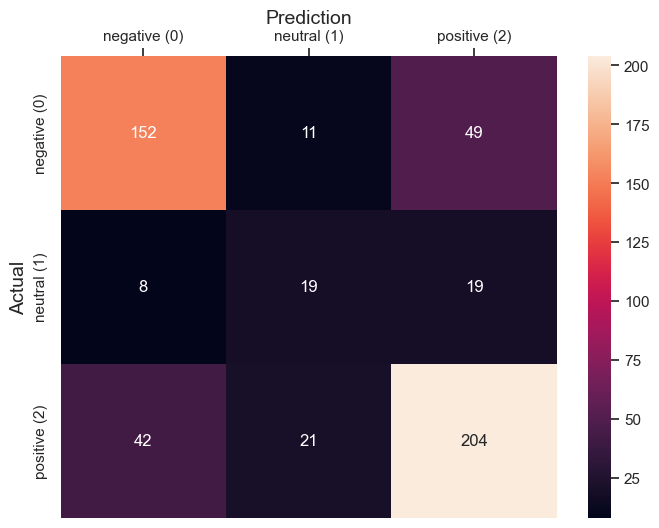

In [356]:
# Predict sentiment on data test by using model has been created, and then visualize a confusion matrix
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Model Accuracy on Test Data:', accuracy)
confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(confusion_matrix(y_true = y_test, y_pred = y_pred), fmt = 'g', annot = True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize = 14)
ax.set_xticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
ax.set_ylabel('Actual', fontsize = 14)
ax.set_yticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
plt.show()

In [357]:
# Results from prediction sentiment on data test
text_clean = tweets_sentimen['text_clean']
text_train, text_test = train_test_split(text_clean, test_size = 0.2, random_state = 0)
result_test = pd.DataFrame(data = zip(text_test, y_pred), columns = ['text', 'polarity'])
polarity_decode = {0 : 'Negative', 1 : 'Neutral', 2 : 'Positive'}
result_test['polarity'] = result_test['polarity'].map(polarity_decode)
pd.set_option('max_colwidth', 300)
result_test

,text,polarity
0,memperingati tahun kedatangan pak jokowi ke pulau buton,Negative
1,csis prabowogibran perlu tim transisi jangan hanya gimmick,Negative
2,akal akalan rezim,Neutral
3,sudahlah pak prabowo mas gibran merupakan pilihan rakyat indonesia bkn pilihan rakyat yaman hargai dong rakyat indonesia yg memilih pemimpinnya lagian doa seorang pembohong seperti bung mustahil di kabulkan salam waras tampilkan lebih banyak,Negative
4,adzan politik ada bacapres muncul adzan maghrib di dua stasiun tv swasta nasional yang nota bene boss nya masuk koalisi pendukung tukang adzan itu kata pendukungnya itu tidak kampanye saya minta kpi menkominfo untuk melakukan tindakan,Positive
...,...,...
520,segini ketentuan besaran dana kampanye pada pemilu,Positive
521,masyarakat menerima hasil pemilu dengan kondusif,Positive
522,liat orangorang pada ngejilat ke pak dan mas serta pak gw jadi inget tweet mas gibran cara menaklukkan anjing adalah dengan memberinya tulang hebatnya setelah tweet ini viral para penjilat itu bukannya sadar malah makin menjadi pada nggak tau malu,Positive
523,walisongo adalah suri tauladan yg hendaknya dimiliki oleh nahdliyyin seperti jg yg dilakukan cak imin gus imin pemimpin visioner komunikatif berwawasan luas dan amanah,Positive


In [364]:
# Initializing and preprocessing new text data
otherData = pd.DataFrame()
otherData['text'] = ['Kebijakan baru pemerintah untuk meningkatkan pendidikan politik sangat diapresiasi.',
                     'Banyak janji politik yang tidak dipenuhi oleh para pejabat terpilih setelah mereka memenangkan pemilihan.',
                     'Anggota parlemen sedang mempertimbangkan revisi undang-undang pemilihan umum untuk meningkatkan integritas proses pemilihan.',
                     'Hari ini cuaca sangat cerah dan menyegarkan',
                     'Saya akan pergi ke supermarket untuk membeli beberapa kebutuhan dapur.',
                     'Saya merasa sangat kecewa dengan hasil ujian saya yang buruk.'
                    ]

otherData['text_clean'] = otherData['text'].apply(cleaningText)
otherData['text_clean'] = otherData['text_clean'].apply(casefoldingText)
otherData.drop(['text'], axis = 1, inplace = True)

otherData['text_preprocessed'] = otherData['text_clean'].apply(tokenizingText)
otherData['text_preprocessed'] = otherData['text_preprocessed'].apply(filteringText)
otherData['text_preprocessed'] = otherData['text_preprocessed'].apply(stemmingText)
otherData

,text_clean,text_preprocessed
0,kebijakan baru pemerintah untuk meningkatkan pendidikan politik sangat diapresiasi,"[bijak, perintah, tingkat, didik, politik, apresiasi]"
1,banyak janji politik yang tidak dipenuhi oleh para pejabat terpilih setelah mereka memenangkan pemilihan,"[janji, politik, penuh, jabat, pilih, menang, pilih]"
2,anggota parlemen sedang mempertimbangkan revisi undangundang pemilihan umum untuk meningkatkan integritas proses pemilihan,"[anggota, parlemen, timbang, revisi, undangundang, pilih, tingkat, integritas, proses, pilih]"
3,hari ini cuaca sangat cerah dan menyegarkan,"[cuaca, cerah, segar]"
4,saya akan pergi ke supermarket untuk membeli beberapa kebutuhan dapur,"[pergi, supermarket, beli, butuh, dapur]"
5,saya merasa sangat kecewa dengan hasil ujian saya yang buruk,"[kecewa, hasil, uji, buruk]"


In [365]:
# Preprocessing text data

# Make text preprocessed (tokenized) to untokenized with toSentence Function
X_otherData = otherData['text_preprocessed'].apply(toSentence)
X_otherData = tokenizer.texts_to_sequences(X_otherData.values)
X_otherData

[[1876, 161, 70, 401, 5, 535],
 [158, 5, 259, 282, 20, 41, 20],
 [447, 6808, 435, 1278, 4419, 20, 70, 1523, 310, 20],
 [4132, 4152],
 [1274, 231],
 [1230, 30, 1023, 847]]

In [366]:
X_otherData = pad_sequences(X_otherData, maxlen = X.shape[1])
X_otherData

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        1876,  161,   70,  401,    5,  535],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  158,
           5,  259,  282,   20,   41,   20],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  447, 6808,  435, 1278,
        4419,   20,   

In [367]:
# Results from prediction sentiment on text data

y_pred_otherData = model.predict(X_otherData)
y_pred_otherData


1/1 [==============================] - 0s 47ms/step


array([2, 0, 0, 2, 1, 2], dtype=int64)

In [368]:
otherData['Result Prediction'] = y_pred_otherData

polarity_decode = {0 : 'Negative', 1 : 'Neutral', 2 : 'Positive'}
otherData['Result Prediction'] = otherData['Result Prediction'].map(polarity_decode)
otherData

,text_clean,text_preprocessed,Result Prediction
0,kebijakan baru pemerintah untuk meningkatkan pendidikan politik sangat diapresiasi,"[bijak, perintah, tingkat, didik, politik, apresiasi]",Positive
1,banyak janji politik yang tidak dipenuhi oleh para pejabat terpilih setelah mereka memenangkan pemilihan,"[janji, politik, penuh, jabat, pilih, menang, pilih]",Negative
2,anggota parlemen sedang mempertimbangkan revisi undangundang pemilihan umum untuk meningkatkan integritas proses pemilihan,"[anggota, parlemen, timbang, revisi, undangundang, pilih, tingkat, integritas, proses, pilih]",Negative
3,hari ini cuaca sangat cerah dan menyegarkan,"[cuaca, cerah, segar]",Positive
4,saya akan pergi ke supermarket untuk membeli beberapa kebutuhan dapur,"[pergi, supermarket, beli, butuh, dapur]",Neutral
5,saya merasa sangat kecewa dengan hasil ujian saya yang buruk,"[kecewa, hasil, uji, buruk]",Positive


In [369]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [370]:
import pickle

# Save the trained model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)


INFO:tensorflow:Assets written to: C:\Users\syair\AppData\Local\Temp\tmpsmu2a43r\assets


INFO:tensorflow:Assets written to: C:\Users\syair\AppData\Local\Temp\tmpsmu2a43r\assets


In [372]:

cnf_mat = confusion_matrix(y_test, y_pred)
TP = np.diag(cnf_mat)
TP = TP.astype(float)
FN = cnf_mat.sum(axis = 1) - TP
FN = FN.astype(float)
FP = cnf_mat.sum(axis = 0) - TP
FP = FP.astype(float)
TN = cnf_mat.sum() - (TP + FN + FP)
TN = TN.astype(float)

# Sensitivity
TPR = TP/(TP+FN)

# Specificity
TNR = TN/(TN+FP)

#Precision
FPR = FP/(TN+FP)

# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

# Classification error
Err = (FP+FN)/(TP+FP+FN+TN)

print('Accuracy = ', ACC.round(2))


Accuracy =  [0.79 0.89 0.75]


GABUNG CSV

In [2]:
df = pd.read_csv('data_all2.csv')

In [3]:
df

,username,handle,postDate,responding,retweets,likes
0,#TeruslahBergerak,@rezasilalahi,2023-09-08T14:59:33.000Z,Replying to \n@akbarfaizal68\n and \n@nagara_inst,NaN,NaN
1,solichin jamaludin,@wakcis,2023-09-08T14:59:08.000Z,"Anies Baswedan bilang, pembangunan tak perlu o...",NaN,NaN
2,Andi Manik,@Andi_Manik,2023-09-08T14:58:49.000Z,Replying to \n@sutanmangara,NaN,NaN
3,Zulfikar Arma x,@ArmaZulfikar,2023-09-08T14:58:36.000Z,Replying to \n@sutanmangara,NaN,NaN
4,rakyatjelita.com,@rakyatjelitacom,2023-09-08T14:58:24.000Z,Replying to \n@seruanhl\n @ch_chotimah2\n and ...,NaN,NaN
...,...,...,...,...,...,...
6890,Angga Saputra,@_anggasptraaa,2023-09-10T08:18:31.000Z,"Prabowo Aksi Terpuji, Bikin Penggemar Terharu!...",NaN,NaN
6891,Reyva aragabriela,@reyvaaragabriel,2023-09-10T08:18:17.000Z,Prabowo: Unhan RI sukses tangani masalah air d...,NaN,NaN
6892,acan,@lexycan72,2023-09-10T08:18:17.000Z,Replying to \n@CakKhum,NaN,NaN
6893,RICH KEY,@Rizkialmudi,2023-09-10T08:18:16.000Z,Replying to \n@AbdulMuntahar6\n @Dennysiregar7...,NaN,NaN


In [4]:
df1 = pd.read_csv('(from KawalPemilu_org).csv')

In [5]:
'''df.drop(columns=['quote_count','reply_count','retweet_count',
                 'favorite_count', 'lang','tweet_url','conversation_id_str',
                 'user_id_str','id_str'], inplace=True)'''

"df.drop(columns=['quote_count','reply_count','retweet_count',\n                 'favorite_count', 'lang','tweet_url','conversation_id_str',\n                 'user_id_str','id_str'], inplace=True)"

In [6]:
df1

,username,handle,postDate,responding,retweets,likes
0,KawalPemilu,@KawalPemilu_org,2024-03-22T00:54:10.000Z,http://Kawalpemilu.org Desak UU Direvisi untuk...,11,35
1,KawalPemilu,@KawalPemilu_org,2024-03-22T00:53:47.000Z,"Revisi UU Pemilu Mendesak, Realisasi Tergantun...",NaN,4
2,KawalPemilu,@KawalPemilu_org,2024-03-20T12:33:54.000Z,Membalas \n@Tati_versteeg72\n @faekri9449\n da...,NaN,1
3,KawalPemilu,@KawalPemilu_org,2024-03-20T12:16:53.000Z,Membalas \n@Eni2345\n @Andi_Rubby\n dan \n@KPU_ID,NaN,NaN
4,KawalPemilu,@KawalPemilu_org,2024-03-20T11:50:52.000Z,Membalas \n@Eni2345\n @Andi_Rubby\n dan \n@KPU_ID,NaN,2
...,...,...,...,...,...,...
361,KawalPemilu,@KawalPemilu_org,2024-02-07T06:34:33.000Z,Terima kasih yuk rame-rame semua cobain ungga...,4,10
362,KawalPemilu,@KawalPemilu_org,2024-02-07T05:48:20.000Z,Terima kasih koh \n@edwardsuhadi\n yang selalu...,2,6
363,KawalPemilu,@KawalPemilu_org,2024-02-07T05:45:43.000Z,Hatur nuhun - cc ke relawan KP yang bikin kilat,2,2
364,KawalPemilu,@KawalPemilu_org,2024-02-07T05:42:16.000Z,Situs http://KawalPemilu.org sudah bisa diguna...,3,6


In [7]:
df2 = pd.read_csv('prabowo.csv')

In [8]:
'''df2.drop(columns=['quote_count','reply_count','retweet_count',
                 'favorite_count', 'lang','tweet_url','conversation_id_str',
                 'user_id_str','id_str'], inplace=True)'''

"df2.drop(columns=['quote_count','reply_count','retweet_count',\n                 'favorite_count', 'lang','tweet_url','conversation_id_str',\n                 'user_id_str','id_str'], inplace=True)"

In [9]:
df2

,username,handle,postDate,responding,retweets,likes
0,Menghadeh.,@umsk_kmosk,2024-03-23T20:34:31.000Z,"Gugatan paslon 3 better, kenapa? Krn prabowo p...",NaN,NaN
1,Tanah Sejuk Mitsaq,@tanah_sejuk,2024-03-23T20:34:13.000Z,Membalas \n@H4T14K4LN4L42\n @jokowi\n dan \n@p...,NaN,NaN
2,Saiful,@saifulteladan,2024-03-23T20:34:11.000Z,Membalas \n@vanc1Bozz\n @Sjaechu\n dan 3 lainnya,NaN,NaN
3,제하페 Jehape 𝕏,@JHPrabowo,2024-03-23T20:34:11.000Z,Gak standar PIPA donk pak kayak dimana gitu \n...,NaN,1.0
4,Raja Elang Putih,@henkoto777,2024-03-23T20:33:33.000Z,SAYA BERSYUKUR TIDAK GABUNG KOALISI ATAU RELAW...,NaN,NaN
...,...,...,...,...,...,...
144,panglima Stegil,@PanglimaSt8233,2024-03-23T18:53:34.000Z,Membalas \n@Zero8ok,NaN,NaN
145,َJ ⸜( ⌓̈ )⸝,@txtdarijias,2024-03-23T18:52:38.000Z,Membalas \n@jankasikendor\n dan \n@kegblgnunfaedh,1.0,29.0
146,wong solo,@Bebek177371222,2024-03-23T18:52:31.000Z,Membalas \n@mas_veel,NaN,NaN
147,CAPRES,@tekashidota,2024-03-23T18:52:09.000Z,Cek Kemeja Flanel Pria Distro Flannel Lengan P...,NaN,NaN


In [10]:
df3 = pd.read_csv('pemilu.csv')

In [11]:
df3

,username,handle,postDate,responding,retweets,likes
0,ira wong,@khoeroo,2024-03-23T18:27:46.000Z,Membalas \n@kegblgnunfaedh,NaN,NaN
1,makroepoon,@penjagadapur,2024-03-23T18:27:29.000Z,ENJOY JADI BAGIAN DARI MAFIA PEMILU DAN MAFIA ...,NaN,NaN
2,Kustanto,@Kustanto10,2024-03-23T18:27:25.000Z,"Jangan cume PilPres, semua pemilu Caleg DPR,DP...",NaN,NaN
3,im just like another people,@openworld33,2024-03-23T18:27:24.000Z,Membalas \n@kegblgnunfaedh,NaN,NaN
4,Bang Sopo,@SopoOfficial,2024-03-23T18:27:10.000Z,Membalas \n@AnggaKalih\n @drakkxen\n dan \n@ke...,NaN,NaN
...,...,...,...,...,...,...
427,Hegel Vilcinsky,@vilcinsky,2024-03-23T14:15:09.000Z,Klo pake argumen ini inggris itu udh hancur so...,NaN,NaN
428,Aryadwiwarna,@Aryadwiwarna1,2024-03-23T14:14:49.000Z,Membalas \n@KayanaDuris\n dan \n@BattoAjax,NaN,NaN
429,P3TI12,@_G03NT03R_,2024-03-23T14:14:41.000Z,Semua orang yg cerdas berakal sehat tau . Pem...,NaN,1.0
430,rian segondang,@segondang24708,2024-03-23T14:14:39.000Z,Membalas \n@abu_waras\n dan \n@KPU_ID,NaN,NaN


In [12]:
df4 = pd.read_csv('gibran.csv')

In [13]:
df4

,username,handle,postDate,responding,retweets,likes
0,Republika.co.id,@republikaonline,2024-03-24T14:12:00.000Z,Demokrat menegaskan koalisi besar pendukung Pr...,NaN,NaN
1,diGENOSIDA'65 رب نجني من القوم الظالمين,@sabronaiditnusa,2024-03-24T14:11:58.000Z,Membalas \n@Little_secret9\n dan \n@convomf,NaN,NaN
2,Don Muzakir,@don_muzakir_,2024-03-24T14:11:57.000Z,"Menyambut Kemenangan Pasangan Prabowo Gibran, ...",NaN,NaN
3,Langgeng,@Langgen27393109,2024-03-24T14:11:47.000Z,Membalas \n@gilang_ahm31272,NaN,NaN
4,"Susanto, SA",@susanto1305,2024-03-24T14:09:46.000Z,Membalas \n@Jangkrikgengg15\n @KompasTV\n dan ...,NaN,NaN
...,...,...,...,...,...,...
389,Qwerty,@xaquily,2024-03-24T09:57:23.000Z,Membalas \n@G0P4NK_G0P4NG_7\n @aniesbaswedan\n...,NaN,NaN
390,gibran basis bratson,@orangsurga,2024-03-24T09:57:23.000Z,Membalas \n@boraheamri\n @expebt\n dan 4 lainnya,NaN,NaN
391,Gibran,@brangbrn,2024-03-24T09:57:19.000Z,Membalas \n@Ribka_JKT48,NaN,NaN
392,MenolakMencret,@arwindras,2024-03-24T09:56:11.000Z,Membalas \n@olym_jae\n @littleg83443669\n dan...,NaN,NaN


In [14]:
all = pd.concat([df, df1, df2, df3, df4])

In [15]:
all

,username,handle,postDate,responding,retweets,likes
0,#TeruslahBergerak,@rezasilalahi,2023-09-08T14:59:33.000Z,Replying to \n@akbarfaizal68\n and \n@nagara_inst,NaN,NaN
1,solichin jamaludin,@wakcis,2023-09-08T14:59:08.000Z,"Anies Baswedan bilang, pembangunan tak perlu o...",NaN,NaN
2,Andi Manik,@Andi_Manik,2023-09-08T14:58:49.000Z,Replying to \n@sutanmangara,NaN,NaN
3,Zulfikar Arma x,@ArmaZulfikar,2023-09-08T14:58:36.000Z,Replying to \n@sutanmangara,NaN,NaN
4,rakyatjelita.com,@rakyatjelitacom,2023-09-08T14:58:24.000Z,Replying to \n@seruanhl\n @ch_chotimah2\n and ...,NaN,NaN
...,...,...,...,...,...,...
389,Qwerty,@xaquily,2024-03-24T09:57:23.000Z,Membalas \n@G0P4NK_G0P4NG_7\n @aniesbaswedan\n...,NaN,NaN
390,gibran basis bratson,@orangsurga,2024-03-24T09:57:23.000Z,Membalas \n@boraheamri\n @expebt\n dan 4 lainnya,NaN,NaN
391,Gibran,@brangbrn,2024-03-24T09:57:19.000Z,Membalas \n@Ribka_JKT48,NaN,NaN
392,MenolakMencret,@arwindras,2024-03-24T09:56:11.000Z,Membalas \n@olym_jae\n @littleg83443669\n dan...,NaN,NaN


In [16]:
all.to_csv('data_all.csv', index=False)